# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Набор данных находится в файле:** autos.csv

**Признаки**:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


**Целевой признак:**

* Price — цена (евро)

## План работы

**Загрузим данные**

**Изучим данные**.
* Заполним или удалим пропущенные значения и обработаем аномалии.
* Если среди признаков имеются неинформативные, удалим их.

**Подготовим выборки для обучения моделей.**

**Обучим разные модели**
* Для каждой модели попробуем разные гиперпараметры

**Проанализируем время обучения, время предсказания и качество моделей.**

**Опираясь на критерии заказчика, выберем лучшую модель.**
* Проверим качество модели на тестовой выборке.**


## Импортируем библиотеки

In [44]:
!pip install catboost --quiet
!pip install category_encoders --quiet

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
import timeit

from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

## Загрузка данных

In [2]:
#Загрузим данные
try:
    data = pd.read_csv('/datasets/autos.csv', sep = ',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep = ',')

Устанавливаем начальный RANDOM_STATE для получения одинаковых и повторяющихся результатов вычислений при использования случайных чисел.

In [3]:
RANDOM_STATE = 12345

In [4]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

**Переименуем все столбцы** для соответствия змеиной нотации

In [5]:
# Переведем наименования столбцов в нижний регистр.
# При этом между прописными и строчными буквами поставим знак нижнего подчеркивания: "_".
# Чтобы разделить составные слова.

data.columns = (data.columns
                .str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True)
                .str.lower()
                )

# Проверим, что столбцы переименовались
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

## Изучение данных

Напишем функцию df_describe для ознакомления с данными в одном датафрейме

In [6]:
def df_describe(df):
    print('Первые 3 строки данных:\n')
    display(df.head(3))

    print('Последние 3 строки данных:\n')
    display(df.head(3))

    print('\nИнформация столбцах, их типах:\n')
    df.info()

    print('\nОбщее описание данных:\n')
    display(df.describe())

    print('\nГистограммы данных:\n')
    data.hist(figsize=(15, 15), rwidth=0.9)
    plt.show()

    print('\nКорреляция между признаками:\n')
    corrMatrix = (data
     #Выбираем только числовые типы данных
     .select_dtypes(include='number')
     #Убираем столбец number_of_pictures, там ругеается на Nan
     .filter(regex='^(?!number_of_pictures)')
     .corr())

    display(corrMatrix.style.background_gradient(cmap='coolwarm'));

### Общий обзор данных

Первые 3 строки данных:



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Последние 3 строки данных:



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46



Информация столбцах, их типах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen         

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Гистограммы данных:



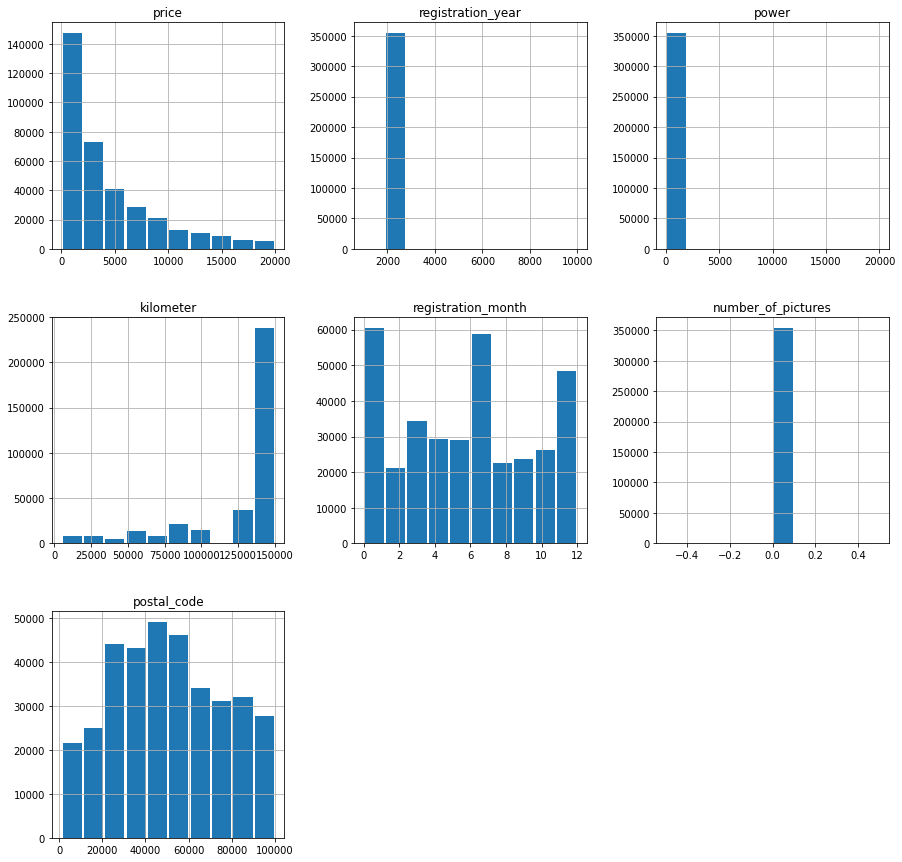


Корреляция между признаками:



,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.026916,0.158872,-0.333199,0.110581,0.076055
registration_year,0.026916,1.000000,-0.000828,-0.053447,-0.011619,-0.003459
power,0.158872,-0.000828,1.000000,0.024002,0.043380,0.021665
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,-0.007698
registration_month,0.110581,-0.011619,0.043380,0.009571,1.000000,0.013995
postal_code,0.076055,-0.003459,0.021665,-0.007698,0.013995,1.000000


In [7]:
df_describe(data)

Изучив данные видим, что в данных есть пропуски. Столбец number_of_pictures не содержит полезных данных. Видимо где-то произошел сбой при парсинге данных и в этом столбце только нули. Этот столбец можно удалить.

Значимой корреляции между признаками не было обнаружен. Есть небольшая корреляция между пробегом и ценой и еще меньшая между мощностью двигателя и ценой автомобиля.

Переведем столбцы с датами в формат даты.

In [8]:
#Переведем в формат даты все столбцы наименование которых начинается с 'date' или 'last'
for data_col in data.filter(regex='^(date|last.+)').columns:
    data[data_col] = pd.to_datetime(
    data[data_col], format='%Y-%m-%dT%H:%M:%S'
    )
    print(data[data_col].head(5))

0   2016-03-24 11:52:17
1   2016-03-24 10:58:45
2   2016-03-14 12:52:21
3   2016-03-17 16:54:04
4   2016-03-31 17:25:20
Name: date_crawled, dtype: datetime64[ns]
0   2016-03-24
1   2016-03-24
2   2016-03-14
3   2016-03-17
4   2016-03-31
Name: date_created, dtype: datetime64[ns]
0   2016-04-07 03:16:57
1   2016-04-07 01:46:50
2   2016-04-05 12:47:46
3   2016-03-17 17:40:17
4   2016-04-06 10:17:21
Name: last_seen, dtype: datetime64[ns]


Посмотрим время, когда загружались обьявления

In [9]:
print(data.date_crawled.min())
print(data.date_crawled.max())

2016-03-05 14:06:22
2016-04-07 14:36:58


### Посмотрим дубликаты в данных

In [10]:
data[data.duplicated(subset =
                     # Ищем полные дубликаты по всем столбцам, исключая  столбцы с датами
                     data.filter(regex='^(?!date|last)')
                     .columns)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
3551,2016-03-22 21:55:08,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,2016-03-22,0,52388,2016-03-22 21:55:08
3786,2016-03-12 11:50:17,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no,2016-03-12,0,32756,2016-03-13 03:15:44
3907,2016-03-26 21:38:04,500,small,1999,manual,55,corsa,150000,12,petrol,opel,no,2016-03-26,0,51377,2016-03-31 19:46:16
4134,2016-03-24 08:53:30,18750,sedan,2014,manual,150,golf,20000,9,gasoline,volkswagen,no,2016-03-24,0,38518,2016-04-06 23:45:06
4222,2016-03-19 21:54:30,14500,wagon,2007,manual,140,a6,100000,3,gasoline,audi,no,2016-03-19,0,94060,2016-04-05 11:49:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05,0,17034,2016-03-06 04:17:37
354337,2016-03-26 14:38:18,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,NaN,2016-03-26,0,4107,2016-04-06 20:45:16
354352,2016-03-06 21:11:23,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no,2016-03-05,0,60437,2016-03-12 12:18:05
354355,2016-03-21 15:36:22,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no,2016-03-21,0,45896,2016-04-06 15:45:01


Имеется довольно много дубликатов. Возможно кролер записывал как различающиеся объявления, когда различалась только дата объявления или только время последней активности продавца.

### Изучим уникальные значения
в категориальных столбцах

In [11]:
for cat_col in (data
                #Выбираем только строковые столбцы
                .select_dtypes(include='object')
                .columns):
    print('******************************')
    #Печатаем название столбца жирным с помощью тэгов HTML
    display(HTML(f"<b>{cat_col}:</b>"))
    print(data[cat_col].value_counts())
    print()

******************************


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

******************************


manual    268251
auto       66285
Name: gearbox, dtype: int64

******************************


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

******************************


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

******************************


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

*************

no     247161
yes     36054
Name: repaired, dtype: int64



Уникальные значения в категориальных признаках выглядят ожидаемым образом.

## Подготовка данных

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Время экспозиции

Используем столбец с разницей между временем создания объявления и временем последней активности пользователя. Чтобы выявить связь между длительностью экспозиции и ценой автомобиля. Предположим, что модель увидит связь, что цена должна быть видимо завышена при прочих равных условиях, если время экспозиции велико.

In [13]:
# Создадим столбей для времени экспозиции
data['diff_days'] =(data['last_seen'] - data['date_created']) / np.timedelta64 ( 1 , 'D')

# Преобразуем признак date_created в формат целого числа для использования в дальнейшем обучении
data['date_created'] = data['date_created'].dt.strftime("%Y%m%d").astype(int)
data.head(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,diff_days
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,20160324,0,70435,2016-04-07 03:16:57,14.136771


### Удаление неинформативных признаков

Удалим неинформативный признак number_of_pictures, так как в нем нет данных. Так же удалим столбец с датой загрузки объявления. Так как если модели и получится найти какую-то связь между временем загрузки объявления и ценой в тренировочных данных, то это будет не нужная связь для дальнейшего применения модели на практике. Остальные даты тоже удалим, будем использовать только разницу между датой создания объявления и последней активностью пользователя. Не будем удаляь дату создания объявления, чтобы учесть год в котором продавался автомобиль, возможную инфляцию и подобные факторы.

In [14]:
data.drop(['number_of_pictures', 'date_crawled', 'last_seen'], axis=1, inplace = True)
data.head(1)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,diff_days
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,20160324,70435,14.136771


### Удалим дубликаты в данных

In [15]:
#data.drop_duplicates(subset =
#                     # Ищем полные дубликаты по всем столбцам, исключая  столбцы с датами
#                     data.filter(regex='^(?!date|last)').columns,
#                     keep='last',
#                     inplace=True)
data.drop_duplicates(keep='last', inplace=True)
data[data.duplicated()]
#data[data.duplicated(subset =
#                     # Ищем полные дубликаты по всем столбцам, исключая  столбцы с датами
#                     data.filter(regex='^(?!date|last)')
#                     .columns)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,diff_days


### Заполним пропуски
в строковых столбцах словом 'missed'. Некоторые модели бустинга могут работать с пропусками как с отдельной категорией. Но в данном проекте будут использоваться и другие модели, для которых необходимо устранить пропуски в данных.

In [16]:
#Выбираем только строковые столбцы
#data.select_dtypes(include='object').fillna('missed', inplace=True)
data.fillna('missed', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354280 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               354280 non-null  int64  
 1   vehicle_type        354280 non-null  object 
 2   registration_year   354280 non-null  int64  
 3   gearbox             354280 non-null  object 
 4   power               354280 non-null  int64  
 5   model               354280 non-null  object 
 6   kilometer           354280 non-null  int64  
 7   registration_month  354280 non-null  int64  
 8   fuel_type           354280 non-null  object 
 9   brand               354280 non-null  object 
 10  repaired            354280 non-null  object 
 11  date_created        354280 non-null  int64  
 12  postal_code         354280 non-null  int64  
 13  diff_days           354280 non-null  float64
dtypes: float64(1), int64(7), object(6)
memory usage: 40.5+ MB


Сбросим индексы после удавления строк

In [17]:
data.reset_index(drop=True, inplace=True)

### Удалим аномальные значения

Признак `price`.



In [18]:
print('Объявлений с ценной 0:', data.query('price == 0').shape[0])

Объявлений с ценной 0: 10771


Признак `registration_year`.

Удалим даты регистрации до 1900 года и после 2017. Так как сбор данных был в 2016 году. Авто 2017 сразу удалять не будем так как может нужно выяснять может быть в этом признаке авто следующего года несут какой-то смысл. Потому что таких авто довольно много и ввод 2017 в 2016 мог быть и не случайной ошибкой и аномалией.

In [19]:
print('Объявлений до удаления:', data.shape[0])
data=data.query('registration_year > 1900 and registration_year < 2018')
print('Объявлений после удаления:', data.shape[0])

Объявлений до удаления: 354280
Объявлений после удаления: 350125


Признак `power`.

Удалим мощности двигателей автомобилей больше 1000. Так как это аномальной высокая мощность и даже если это реальные автомобили, а не ошибка, они вероятно будут слишком редкими чтобы модель хорошо обучилась предсказывать их цену. В Данных есть много автомобилей с мощностью 0. Но их удалять не будем, будем считать 0 мощности это заглушкой, сигнализирующей отсутствие данных.

In [20]:
data=data.query('power < 1000')
print('Объявлений с мощностью 0:', data.query('power == 0').shape[0])
print('Объявлений после удаления:', data.shape[0])

Объявлений с мощностью 0: 39110
Объявлений после удаления: 349829


Заменяем на столбце `power` с мощностью 0 на средний мощзность с помощью функции `median()`

In [21]:
data.loc[(data['power'] == 0), 'power'] = data['power'].median()

Признак `kilometer`.

В признаке пробег не было обнаружено аномальных значений. Пробег укладывается в нормальные 150 тыс. км. Что довольно неожиданно так как должны быть и реальные автомобили с большим пробегом. Возможно продавцы не всегда указывают реальный пробег.

Признак `registration_month`.

Есть значительное число данных с месяцем регистрации 0. Не будем их удалять так как этих данных довольно много с одной стороны. А с другой стороны можно считать величину 0 заглушкой, сигнализирующей об отсутствии данных.

In [22]:
print('Объявлений с месяцем регистрации 0:', data.query('registration_month == 0').shape[0])

Объявлений с месяцем регистрации 0: 36290


In [40]:
print('Объявлений с ценной 0:', data.query('price == 0').shape[0])

Объявлений с ценной 0: 10538


In [41]:
data.loc[(data['price'] == 0), 'price'] = data['price'].median()

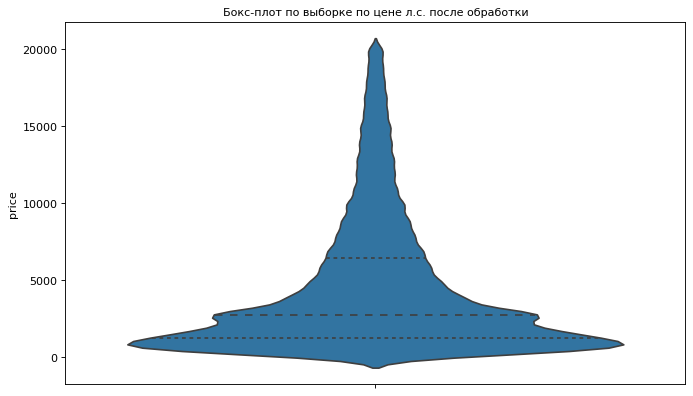

In [45]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='price', data=data, scale='width', inner='quartile', grid=True)

# Decoration
plt.title('Бокс-плот по выборке по цене л.с. после обработки', fontsize=10)
plt.show()

## Обучение моделей

### Разобьем данные на выборки

In [23]:
# Выделим обучающую выборку для кросс валидации: 'train' и тестовую: 'test'
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price', axis=1),
    data['price'],
    test_size=0.25, random_state=RANDOM_STATE)

# Проверим размер выборок
print('train -', len(X_train), len(y_train))
print('test -',len(X_test), len(y_test))

train - 262371 262371
test - 87458 87458


### Трансформируем категориальные признаки
С помощью TargetEncoder переведем категориальные строковые столбцы в числовой формат. Закодированные таким образом категориальные признаки будем использовать только для модели RandomForest.

In [24]:
# Найдем категориальные признаки
cat_features = data.select_dtypes(include='object').columns.tolist()

tenc=TargetEncoder()
# Проводим трансформацию категориальных столбцов cat_features для тренировочной выборки используя целевой признак y_train
df=tenc.fit_transform(X_train[cat_features], y_train)
X_train_cat = df.join(X_train.drop(cat_features, axis = 1))
display(X_train_cat.head(3))

# Проводим трансформацию тестовойвыборки на ранее обученном кодировщике tenc без испольования целевого признака y_test (чтобы не было утечки целевого признака)
df=tenc.transform(X_test[cat_features])
X_test_cat = df.join(X_test.drop(cat_features, axis = 1))
display(X_test_cat.head(3))

,vehicle_type,gearbox,model,fuel_type,brand,repaired,registration_year,power,kilometer,registration_month,date_created,postal_code,diff_days
4439,5473.392793,6841.387339,6708.582226,3752.477271,4392.243861,5300.666073,1992,110.0,150000,5,20160306,15711,31.448912
306121,6033.562238,3984.601158,9907.209249,6577.942148,6182.198664,5300.666073,2011,204.0,100000,4,20160307,46485,3.552338
128869,2671.586828,3984.601158,1381.300525,3752.477271,2285.424371,5300.666073,2001,58.0,150000,3,20160323,32107,0.696713


,vehicle_type,gearbox,model,fuel_type,brand,repaired,registration_year,power,kilometer,registration_month,date_created,postal_code,diff_days
304250,4715.177069,6841.387339,4518.729816,3752.477271,4392.243861,5300.666073,2006,150.0,60000,3,20160325,21033,12.947928
210452,6806.108221,3984.601158,2598.099831,3752.477271,2721.824666,5300.666073,2008,90.0,125000,4,20160315,23845,18.323056
282839,2233.466656,6841.387339,6194.649446,3752.477271,5910.789705,5300.666073,2000,105.0,150000,11,20160323,13347,0.653750


### Обучим LGBMRegressor

Отметим категориальные столбцы

In [25]:
X_train_type = X_train.copy()
X_test_type = X_test.copy()
for col in cat_features:
  X_train_type[col] = X_train_type[col].astype('category')
  X_test_type[col] = X_test_type[col].astype('category')

X_train_type.info()
X_test_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262371 entries, 4439 to 220349
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        262371 non-null  category
 1   registration_year   262371 non-null  int64   
 2   gearbox             262371 non-null  category
 3   power               262371 non-null  float64 
 4   model               262371 non-null  category
 5   kilometer           262371 non-null  int64   
 6   registration_month  262371 non-null  int64   
 7   fuel_type           262371 non-null  category
 8   brand               262371 non-null  category
 9   repaired            262371 non-null  category
 10  date_created        262371 non-null  int64   
 11  postal_code         262371 non-null  int64   
 12  diff_days           262371 non-null  float64 
dtypes: category(6), float64(2), int64(5)
memory usage: 25.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87458 e

Обучим модель LGBMRegressor на тренировочной выборке с кросвалидацией и подбором параметров с помощью GridSearchCV

In [26]:
%%time
# Гиперпараметры для перебора
param_grid_lgb = {
    'learning_rate': [0.15, 0.1],
    'n_estimators': [100, 300]
}

# Инициализируем LGBMRegressor estimattor
estimator = lgb.LGBMRegressor(objective='regression',
                              random_state=RANDOM_STATE,
                              n_estimators=300)

# Инициализируем Grid Search
model_lgb = GridSearchCV(estimator=estimator,
                     param_grid=param_grid_lgb,
                     cv=3,
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=1)
model_lgb.fit(X_train_type, y_train)

# Выводим лучшие параметры поиска
print('LGBMRegressor:')
print(f'Лучшие параметры: {model_lgb.best_params_}')
print(f'RMSE для лучших параметров:', round(model_lgb.best_score_*(-1), 2))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
LGBMRegressor:
Лучшие параметры: {'learning_rate': 0.15, 'n_estimators': 300}
RMSE для лучших параметров: 1691.57
CPU times: user 2min 27s, sys: 553 ms, total: 2min 28s
Wall time: 2min 29s


### Обучим CatBoostRegressor

In [27]:
%%time

param_grid_cat_boost = {
    'depth': [6, 10],
    'learning_rate': [0.1, 0.03],
}

# Инициализируем CatBoostRegressor estimattor
estimator = CatBoostRegressor(loss_function="RMSE", iterations=100, random_state=RANDOM_STATE)

# Инициализируем Grid Search
model_cat_boost = GridSearchCV(estimator=estimator,
                     param_grid=param_grid_cat_boost,
                     cv=3,
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=10)
model_cat_boost.fit(X_train, y_train, cat_features=cat_features, verbose=10)

# Выводим лучшие параметры поиска
print('CatBoostRegressor:')
print(f'Лучшие параметры: {model_cat_boost.best_params_}')
print(f'RMSE для лучших параметров:', round(model_cat_boost.best_score_*(-1), 2))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START depth=6, learning_rate=0.1..................................
0:	learn: 4240.1252195	total: 144ms	remaining: 14.2s
10:	learn: 2749.6619624	total: 778ms	remaining: 6.29s
20:	learn: 2283.6497894	total: 1.38s	remaining: 5.21s
30:	learn: 2101.1313233	total: 2.01s	remaining: 4.47s
40:	learn: 2022.1510484	total: 2.62s	remaining: 3.77s
50:	learn: 1977.3522445	total: 3.24s	remaining: 3.11s
60:	learn: 1944.5722722	total: 3.92s	remaining: 2.51s
70:	learn: 1919.9999960	total: 4.53s	remaining: 1.85s
80:	learn: 1893.5712789	total: 5.16s	remaining: 1.21s
90:	learn: 1876.3319499	total: 5.8s	remaining: 574ms
99:	learn: 1863.7751620	total: 6.35s	remaining: 0us
[CV 1/3; 1/4] END ................depth=6, learning_rate=0.1; total time=   7.7s
[CV 2/3; 1/4] START depth=6, learning_rate=0.1..................................
0:	learn: 4239.0707331	total: 72.9ms	remaining: 7.22s
10:	learn: 2757.6903074	total: 726ms	remaining: 5.87s

### Обучим RandomForestRegressor
на тренировочной выборке с кросвалидацией и подбором параметров с помощью GridSearchCV

In [28]:
%%time
# Гиперпараметры для перебора

param_forest = {
    'max_depth': [5, 10],
    'n_estimators': [20, 50]
}

# Инициализируем RandomForestRegressor estimattor
estimator = RandomForestRegressor(random_state=RANDOM_STATE)

# Инициализируем Grid Search
model_forest  = GridSearchCV(estimator=estimator,
                     param_grid=param_forest,
                     cv=3,
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=1)
model_forest.fit(X_train_cat, y_train)

# Выводим лучшие параметры поиска
print('LGBMRegressor:')
print(f'Лучшие параметры: {model_forest .best_params_}')
print(f'RMSE для лучших параметров:', round(model_forest .best_score_*(-1), 2))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
LGBMRegressor:
Лучшие параметры: {'max_depth': 10, 'n_estimators': 50}
RMSE для лучших параметров: 1919.69
CPU times: user 3min 23s, sys: 237 ms, total: 3min 24s
Wall time: 3min 24s


## Анализ моделей

Создадим датафрейм comp. В который будем записывать параметры моделей.

In [29]:
index = ['RMSE', 'Время обучения (c)', 'Время предсказания (c)']

# создаем список колонок
columns = ['LGBMRegressor', 'CatBoostRegressor', 'RandomForestRegressor']

# создаем пустой DataFrame с заданными индексами и колонками
comp = pd.DataFrame(index=index, columns=columns)
comp

,LGBMRegressor,CatBoostRegressor,RandomForestRegressor
RMSE,NaN,NaN,NaN
Время обучения (c),NaN,NaN,NaN
Время предсказания (c),NaN,NaN,NaN


### Качество моделей при  кросс валидации. RMSE:

In [30]:
comp.loc['RMSE', 'LGBMRegressor'] = model_lgb.best_score_*(-1)
comp.loc['RMSE', 'CatBoostRegressor'] = model_cat_boost.best_score_*(-1)
comp.loc['RMSE', 'RandomForestRegressor'] = model_forest .best_score_*(-1)

### Время обучения моделей:
* LGBMRegressor: **CPU times: 11s, Wall time: 57s**
* CatBoostRegressor: CPU times: 44 s, Wall time: 2min 50s
* RandomForestRegressor: CPU times: 58 s, Wall time: 4min 13s

In [31]:
# LGBMRegressor
model = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE,
                          depth = 10, learning_rate = 0.1,
                          n_estimators=300)
comp.loc['Время обучения (c)', 'LGBMRegressor'] = timeit.timeit(
    lambda: model.fit(X_train_type, y_train), number=1)

# CatBoostRegressor
model = CatBoostRegressor(loss_function="RMSE", random_state=RANDOM_STATE,
                          depth = 10, learning_rate = 0.1,
                          iterations=100)
comp.loc['Время обучения (c)', 'CatBoostRegressor'] = timeit.timeit(
    lambda: model.fit(X_train, y_train, cat_features=cat_features, verbose=50), number=1)

# RandomForestRegressor
model = RandomForestRegressor(random_state=RANDOM_STATE,
                              max_depth = 10, n_estimators = 50)
comp.loc['Время обучения (c)', 'RandomForestRegressor'] = timeit.timeit(
    lambda: model.fit(X_train_cat, y_train), number=1)

0:	learn: 4210.5297313	total: 216ms	remaining: 21.4s
50:	learn: 1832.1643765	total: 8.8s	remaining: 8.46s
99:	learn: 1725.5043829	total: 17.6s	remaining: 0us


### Время предсказания
Проверим время предсказания моделей на тренировочной выборке

LGBMRegressor

In [32]:
comp.loc['Время предсказания (c)', 'LGBMRegressor'] = timeit.timeit(
    lambda: model_lgb.predict(X_train_type), number=1)

CatBoostRegressor

In [33]:
comp.loc['Время предсказания (c)', 'CatBoostRegressor'] = timeit.timeit(
    lambda: model_cat_boost.predict(X_train), number=1)

RandomForestRegressor

In [34]:
comp.loc['Время предсказания (c)', 'RandomForestRegressor'] = timeit.timeit(
    lambda: model_forest.predict(X_train_cat), number=1)

Лучшее время предсказаний у CatBoostRegressor. Почти в два раза быстрее чем у двух других моделей

In [35]:
comp.round(2)

,LGBMRegressor,CatBoostRegressor,RandomForestRegressor
RMSE,1691.567611,1781.724947,1919.688106
Время обучения (c),26.023227,18.951097,42.104484
Время предсказания (c),5.629198,0.380596,1.111106


### Предсказание на тестовой выборке
В целом, лучшей обученной моделью в данном проекте оказался **LGBMRegressor**. Он оказал лучшую метрику качества RMSE при кроссвалидации. А так же лучшее время обучения. При этом уступил в скорости предсказаний CatBoostRegressor. Поэтому если бы была необходима более высокая скорость предсказаний и менее важна скорость обучения, при приемлемом качестве то можно было бы выбрать CatBoostRegressor.

В качестве модели для проверки предсказаний на тестовой выборке выберем LGBMRegressor.

In [36]:
prediction_lgb = model_lgb.predict(X_test_type)
print('RMSE = ', round(mean_squared_error(y_test, prediction_lgb, squared=False),2))

RMSE =  1675.9


### RMSE по моделям авто

Ознакомимся с качеством предсказаний модели на тестовой выборке в разрезе по моделям. Для каждой модели автомобиля отдельно проверим RMSE предсказаний модели.

In [37]:
#Скапируем тестовую выборку в отдельный датафрейм X_rmse.
X_rmse = X_test_type.copy()

#Добавим к датафрейму X_rmse с признаками целевой признак и предсказания prediction
X_rmse['y'] = y_test
X_rmse['predict'] = prediction_lgb

#Посчитаем RMSE отдельно для каждой модели
rmse_by_model = X_rmse.groupby('model').apply(lambda x: mean_squared_error(x['y'], x['predict'], squared=False))

#Выведем результат на экран
pd.set_option('display.max_rows', 300)
print('RMSE предсказания цены для различных моделей автомобилей:')
print(rmse_by_model.head(300))
pd.set_option('display.max_rows', 10)

RMSE предсказания цены для различных моделей автомобилей:
model
100                  1328.264921
145                   640.795219
147                   831.782537
156                   871.163919
159                  2419.645741
1_reihe               592.488940
1er                  1814.995558
200                  3078.819868
2_reihe               867.330053
300c                 2893.803742
3_reihe              1088.074583
3er                  1769.088077
4_reihe              1412.970937
500                  1518.677844
5_reihe              1929.030708
5er                  2075.459098
601                  1157.756746
6_reihe              1135.440942
6er                  3589.180812
7er                  2393.319002
80                   1274.702456
850                  1163.008639
90                   3063.179234
900                  2201.812544
9000                 1070.405691
911                  4981.829560
a1                   1984.301114
a2                   1469.615086
a3          

Видим, что для разных моделей автомобилей было достигнут разный уровень качества предсказаний. Для некоторых массовых автомобилей среднеквадратичная ошибка предсказаний RMSE сравнительно невысока. Скажем для модели corolla RMSE составляет 967. В то время как для более крупных, дорогих и редких автомобилей ошибка может быть выше. Например для amarok RMSE оказалось 6900.

### Важность факторов

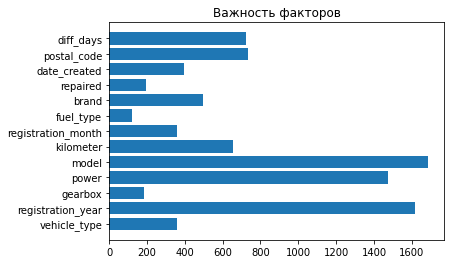

In [38]:
best_model = model_lgb.best_estimator_
importance_values = best_model.feature_importances_
features = X_train_type.columns
importance_values = best_model.feature_importances_

plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.title("Важность факторов")
plt.show()

Можно видеть, что наиболее важным фактором, влияющим на цену автомобиля ожидаемо оказалась модель авто. Вторым по значимости фактором оказался год регстрации автомобиля. Наименее значимым фактором оказалася тип топлива автомобиля.

## Общий вывод

**Загрузка и изучение данных**

Данные были успешно загружены.

Изучив данные увидели, что в данный есть пропуски. Столбец number_of_pictures не содержит полезных данных. Видимо где-то произошел сбой при парсинге данных и в этом столбце только нули. Этот столбец можно удалить.

Значимой корреляции между признаками не было обнаружен. Есть небольшая корреляция между пробегом и ценой и еще меньшая между мощностью двигателя и ценой автомобиля.

Имеется довольно много дубликатов. Видимо кролер записывал как различающиеся объявления, когда различалась только дата объявления или только время последней активности продавца.

**Подготовка данных**

Был  создан столбец с разницей между временем создания объявления и временем последней активности пользователя. Чтобы выявить связь между длительностью экспозиции и ценой автомобиля.

Были удален столбец с числом картинок, так как в нем нет данных. А так же столбцы с датами событий, которые не влияют на цену автомобиля (скажем время загрузки объявления кролером)

Были удалены дубликаты. Пропуски были заполнены значением `missed`.

Были удалнны аномальные значения. А именно объявления с датами регистрации авто после 2017 года, слишком мощными двигателями выше 1000 лс.

**Обучение моделей**

Данные были разбиты на выборки. Была проведена трансформация катеогриальных признаков методом TargetEncoder для того чтобы с категориальными признаками могла работать модель RandomForestRegressor.

Были обучены следующие модели:

* LGBMRegressor
* CatBoostRegressor
* RandomForestRegressor

**Анализ моделей**

|index|LGBMRegressor|CatBoostRegressor|RandomForestRegressor|
|---|---|---|---|
|RMSE|1685\.3|1775\.37|1909\.7|
|Время обучения \(c\)|3\.72|13\.85|42\.29|
|Время предсказания \(c\)|2\.98|0\.26|0\.92|

В целом, лучшей обученной моделью в данном проекте оказался **LGBMRegressor**. Он оказал лучшую метрику качества RMSE при кроссвалидации. А так же лучшее время обучения. При этом уступил в скорости предсказаний CatBoostRegressor. Поэтому если бы была необходима более высокая скорость предсказаний и менее важна скорость обучения, при приемлемом качестве то можно было бы выбрать CatBoostRegressor.

В качестве модели для проверки предсказаний на тестовой выборке выберем LGBMRegressor.

На тестовой выборке модель LGBMRegressor показала RMSE =  1672

**Для лучшей модели LGBMRegressor был проведен анализ RMSE в разрезе по маркам автомобилей**

Дя разных моделей автомобилей было достигнут разный уровень качества предсказаний. Для некоторых массовых автомобилей среднеквадратичная ошибка предсказаний RMSE сравнительно невысока. Скажем для модели corolla RMSE составляет 967. В то время как для более крупных, дорогих и редких автомобилей ошибка может быть выше. Например для amarok RMSE оказалось 6900.

**Для лучшей модели LGBMRegressor был проведен анализ важности факторов**

Наиболее важным фактором, влияющим на цену автомобиля ожидаемо, оказалась модель авто. Вторым по значимости фактором оказался год регстрации автомобиля. Наименее значимым фактором оказалася тип топлива автомобиля.